In [17]:
# Cell 1: Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%pip install prettytable



Note: you may need to restart the kernel to use updated packages.


In [4]:
# Cell 2: Define helper functions for the multimodal model (Samley model)

def load_prediction_files(file_paths):
    """
    Loads multiple prediction CSV files (with header) and concatenates them into one DataFrame.
    Assumes all files share the same column structure.
    """
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file)
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def convert_predictions(df, decision_column="Multimodal_Decision"):
    """
    Converts decision texts ('benign', 'phishing') into binary values:
    benign = 0, phishing = 1.
    """
    mapping = {"benign": 0, "phishing": 1}
    df['pred_label'] = df[decision_column].map(mapping)
    return df

def add_probability_score(df):
    """
    Creates a continuous score for ROC AUC calculation.
    This example uses the average of the 'Image Phish Score' and 'Text Phish Score'
    """
    df['Image Phish Score'] = df['Image Phish Score'].astype(float)
    df['Text Phish Score'] = df['Text Phish Score'].astype(float)
    df['fused_score'] = (df['Image Phish Score'] + df['Text Phish Score']) / 2.0
    return df

def merge_with_ground_truth(predictions_df, ground_truth_file):
    """
    Merges the predictions DataFrame with the ground truth labels from test.csv.
    The merge is done on the 'url' column. Assumes test.csv has a 'url' column and a 'label' column.
    """
    truth_df = pd.read_csv(ground_truth_file)
    merged_df = pd.merge(predictions_df, truth_df[['url', 'label']], on='url', how='inner')
    return merged_df

def compute_metrics(merged_df):
    """
    Computes evaluation metrics:
      - Confusion matrix (extracting FP and FN)
      - Accuracy, precision, recall
      - ROC AUC using a continuous score (fused_score)
    Returns a dictionary with the metrics.
    """
    y_true = merged_df['label']
    y_pred = merged_df['pred_label']
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    
    try:
        roc_auc = roc_auc_score(y_true, merged_df['fused_score'])
    except ValueError:
        roc_auc = np.nan

    metrics = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }
    return metrics

def plot_roc_curve(merged_df, title="ROC Curve"):
    """
    Plots the ROC curve based on the continuous score 'fused_score'
    """
    y_true = merged_df['label']
    y_score = merged_df['fused_score']
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='best')
    plt.show()


In [5]:
# Cell 3: File paths for the Samley model prediction CSV files
samley_prediction_files = [
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_benign_with_logo.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_benign_without_logo.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_Fresh_Logo_Phishing.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_Learned_Logo_Phishing.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_No_Logo_Phishing.csv"
]

ground_truth_file = "/home/tiffanybao/PhishIntention/datasets/test.csv"

# Load predictions
samley_df = load_prediction_files(samley_prediction_files)

# Convert decisions to binary labels
samley_df = convert_predictions(samley_df, decision_column="Multimodal_Decision")

# Create a continuous fused score for ROC AUC
samley_df = add_probability_score(samley_df)

# Merge with ground truth
samley_merged = merge_with_ground_truth(samley_df, ground_truth_file)

# Compute performance metrics
samley_metrics = compute_metrics(samley_merged)
print("Samley Model Evaluation Metrics:")
for metric, value in samley_metrics.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")


Samley Model Evaluation Metrics:
TP: 474
TN: 375
FP: 26
FN: 245
accuracy: 0.7580
precision: 0.9480
recall: 0.6592
roc_auc: 0.8668


In [6]:
# Cell 5: Define helper functions for the original model predictions

def load_original_prediction_files(file_paths):
    """
    Loads multiple original model prediction CSV files (which have no header)
    and concatenates them into one DataFrame.
    Assumes columns in order: 
      Site Folder, url, pred_decision, col4, col5, score.
    """
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file, header=None, names=["Site Folder", "url", "pred_decision", "col4", "col5", "score"])
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def convert_predictions_ori(df):
    """
    For the original model, the predictions are already numeric:
    - 'pred_decision' is 0 (benign) or 1 (phishing).
    - 'score' is a continuous value.
    Sets these as 'pred_label' and 'fused_score' respectively.
    """
    df['pred_label'] = df['pred_decision'].astype(int)
    df['fused_score'] = df['score'].astype(float)
    return df


In [25]:
# Cell 6: File paths for the original model prediction CSV files
ori_prediction_files = [
    "/home/tiffanybao/PhishIntention/results/4.12/ori_common_benign_with_logo.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/ori_common_benign_without_logo.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/ori_common_Fresh_Logo_Phishing.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/ori_common_Learned_Logo_Phishing.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/ori_common_No_Logo_Phishing.csv"
]

def load_original_prediction_files(file_paths):
    """
    Loads multiple original model prediction CSV files which have headers.
    The expected columns are: folder, url, phish_category, pred_target, matched_domain, siamese_conf.
    """
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file)  # CSVs have headers
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def convert_predictions_ori(df):
    """
    For the original model:
      - 'phish_category' is the binary decision (1: phishing, 0: benign).
      - 'siamese_conf' is the continuous confidence score.
    We assign these to 'pred_label' and 'fused_score' respectively.
    """
    df['pred_label'] = df['phish_category'].astype(int)
    df['fused_score'] = df['siamese_conf'].astype(float)
    return df

# Load original model predictions
ori_df = load_original_prediction_files(ori_prediction_files)

# Convert the predictions (assign binary labels and continuous score)
ori_df = convert_predictions_ori(ori_df)

# Merge with ground truth
ori_merged = merge_with_ground_truth(ori_df, ground_truth_file)

# Compute performance metrics
ori_metrics = compute_metrics(ori_merged)
print("Original Model Evaluation Metrics:")
for metric, value in ori_metrics.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")


Original Model Evaluation Metrics:
TP: 147
TN: 401
FP: 0
FN: 572
accuracy: 0.4893
precision: 1.0000
recall: 0.2045
roc_auc: nan


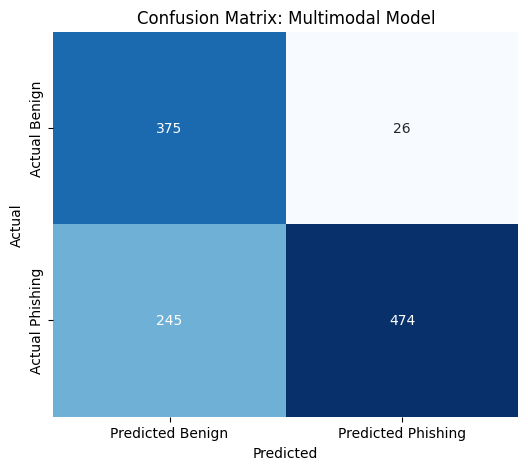

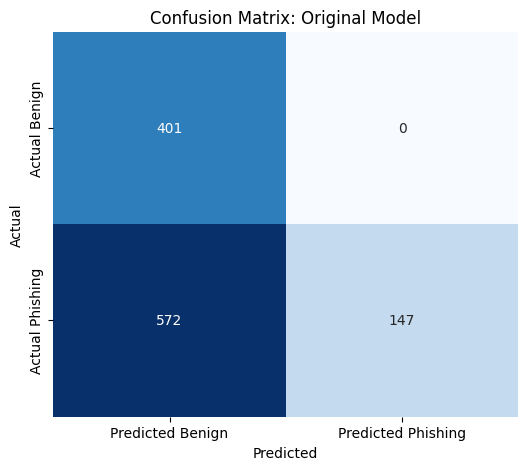

In [26]:
# Cell X: Plot Confusion Matrix for a given merged dataframe

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(merged_df, model_name):
    y_true = merged_df['label']
    y_pred = merged_df['pred_label']
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Benign','Predicted Phishing'],
                yticklabels=['Actual Benign','Actual Phishing'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Example usage:
plot_confusion_matrix(samley_merged, "Multimodal Model")
plot_confusion_matrix(ori_merged, "Original Model")


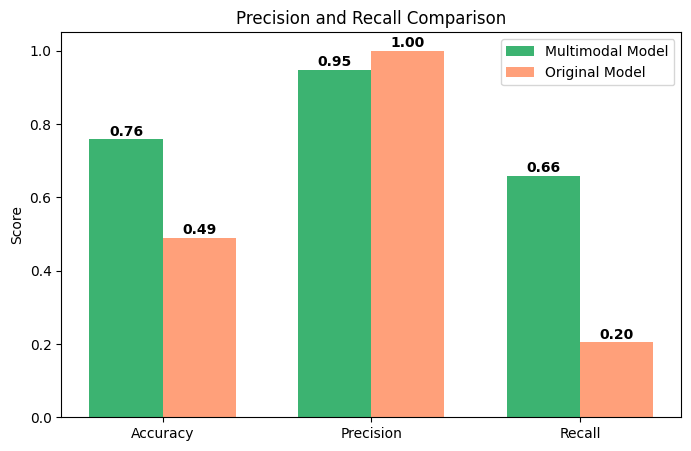

In [27]:
# Cell Y: Visualize Precision and Recall as Bar Charts

# Assuming you have computed precision and recall in your metrics dictionary:

samley_recall = samley_metrics.get('accuracy', 0)
ori_recall    = ori_metrics.get('accuracy', 0)

samley_precision = samley_metrics.get('precision', 0)
ori_precision    = ori_metrics.get('precision', 0)

samley_recall = samley_metrics.get('recall', 0)
ori_recall    = ori_metrics.get('recall', 0)



metrics_labels = ['Accuracy','Precision', 'Recall']
samley_values = [samley_accuracy, samley_precision, samley_recall]
ori_values = [ori_accuracy, ori_precision, ori_recall]

x = np.arange(len(metrics_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, samley_values, width, label='Multimodal Model', color='mediumseagreen')
ax.bar(x + width/2, ori_values, width, label='Original Model', color='lightsalmon')

ax.set_ylabel('Score')
ax.set_title('Precision and Recall Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend()

for i, v in enumerate(samley_values):
    ax.text(x[i]-width/2, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
for i, v in enumerate(ori_values):
    ax.text(x[i]+width/2, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')

plt.show()


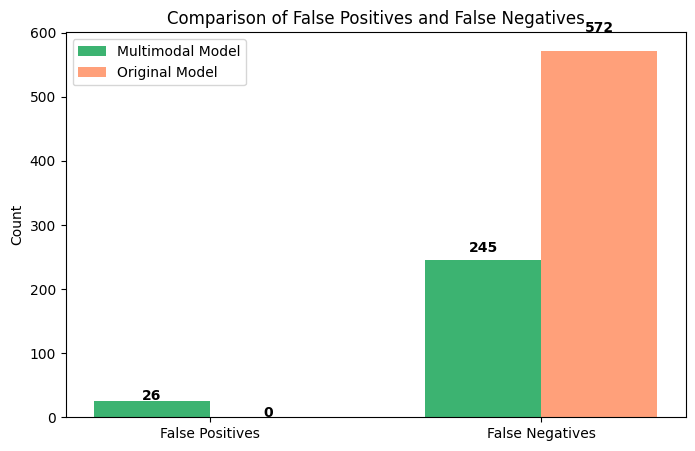

In [28]:
# Cell: Visualize FP and FN as Bar Charts

import matplotlib.pyplot as plt
import numpy as np

# Extract FP and FN values from the metrics dictionaries
samley_FP = samley_metrics.get('FP', 0)
ori_FP = ori_metrics.get('FP', 0)

samley_FN = samley_metrics.get('FN', 0)
ori_FN = ori_metrics.get('FN', 0)

# Define the metrics labels and corresponding values for each model
metrics_labels = ['False Positives', 'False Negatives']
samley_values = [samley_FP, samley_FN]
ori_values = [ori_FP, ori_FN]

# Set the positions for the bars
x = np.arange(len(metrics_labels))
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars for each model
ax.bar(x - width/2, samley_values, width, label='Multimodal Model', color='mediumseagreen')
ax.bar(x + width/2, ori_values, width, label='Original Model', color='lightsalmon')

# Set labels and title
ax.set_ylabel('Count')
ax.set_title('Comparison of False Positives and False Negatives')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend()

# Annotate each bar with its value
for i, v in enumerate(samley_values):
    ax.text(x[i] - width/2, v + max(1, 0.05*v), f"{v}", ha='center', fontweight='bold')
for i, v in enumerate(ori_values):
    ax.text(x[i] + width/2, v + max(1, 0.05*v), f"{v}", ha='center', fontweight='bold')

plt.show()


In [29]:
# Cell Z: Create a metrics summary table

from prettytable import PrettyTable

# Option 1: Using a Pandas DataFrame for better display in notebooks
summary_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'False Positives', 'False Negatives'],
    'Multimodal Model': [samley_metrics['accuracy'], samley_metrics['precision'], samley_metrics['recall'],
                     samley_metrics['FP'], samley_metrics['FN']],
    'Original Model': [ori_metrics['accuracy'], ori_metrics['precision'], ori_metrics['recall'],
                       ori_metrics['FP'], ori_metrics['FN']]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

# Option 2: Using PrettyTable if you want a textual table
table = PrettyTable()
table.field_names = ["Metric", "Multimodal Model", "Original Model"]

for metric in summary_data['Metric']:
    if metric == 'Accuracy' or metric == 'Precision' or metric == 'Recall':
        idx = summary_data['Metric'].index(metric)
        table.add_row([metric,
                       f"{summary_data['Multimodal Model'][idx]:.2f}",
                       f"{summary_data['Original Model'][idx]:.2f}"])
    else:
        idx = summary_data['Metric'].index(metric)
        table.add_row([metric,
                       summary_data['Multimodal Model'][idx],
                       summary_data['Original Model'][idx]])
print(table)


,Metric,Multimodal Model,Original Model
0,Accuracy,0.758036,0.489286
1,Precision,0.948000,1.000000
2,Recall,0.659249,0.204451
3,False Positives,26.000000,0.000000
4,False Negatives,245.000000,572.000000


+-----------------+------------------+----------------+
|      Metric     | Multimodal Model | Original Model |
+-----------------+------------------+----------------+
|     Accuracy    |       0.76       |      0.49      |
|    Precision    |       0.95       |      1.00      |
|      Recall     |       0.66       |      0.20      |
| False Positives |        26        |       0        |
| False Negatives |       245        |      572       |
+-----------------+------------------+----------------+
